In [28]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import pandas as pd

### Carga de datos

In [29]:
df = pd.read_csv('data/Finaltrain.csv')
df = df.sample(frac=1).reset_index(drop=True)
train_data = df[:int(0.8*len(df))]
test_data = df[int(0.8*len(df)):]

train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)


In [30]:
train_data.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_length,word_count,number_count,punctuation_count,stopword_count
0,367edcfcaab1,39c16e,"According to Aristotle, an ideal tradgedy shou...",0.360676,0.500911,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to ...,539,89,0,17,37
1,804b77710f6e,39c16e,"An ideal tragedy, as described by Aristotle ha...",0.205683,0.380538,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to ...,297,52,1,6,23
2,b5584547158b,3b9047,The goverment was very small in size of slaves...,-0.687288,-0.460886,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structure...,252,49,0,2,26
3,8099dd414c8e,814d6b,the third wave developed because a teacher wa...,0.376374,0.463619,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave ex...,400,67,0,2,34
4,f906b5407400,ebad26,A way the facotry would use or cover up spoile...,0.402563,0.790368,Summarize the various ways the factory would u...,Excerpt from The Jungle,With one member trimming beef ...,561,113,0,13,49


In [31]:
train_data['text'].tolist()

['According to Aristotle, an ideal tradgedy should imclude no downfall of the villain character. Aristotle says this beacause he states that killing the villain, "would inspire neither pity nor fear,\' becasue pity comes from undesreved misfortune. Another point an ideal tradgedy should include is a character who is not famous for being good, and one whose misfortune is brought to him by a mistake or error. So, the movie"Batman vs Superman: Dawn of Justice" would not be considered an ideal tragedy. (Ran out of time for the third point).',
 'An ideal tragedy, as described by Aristotle has 3 elements. One of which is a well-constructed plot, another is that it be written about not perfect men whose lives fall apart because of one mistake. The last is that a tragedy should imitate actions that excite pity and fear for the characters.  ',
 'The goverment was very small in size of slaves and there were alot of middle class and the higher class was the pharoh and the priests and the nobles. 

### Uso de BertTokenizer

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer.batch_encode_plus(
    train_data['text'].tolist(),
    truncation=True,
    padding=True
)

test_encodings = tokenizer.batch_encode_plus(
    test_data['text'].tolist(),
    truncation=True,
    padding=True
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_data['content'].tolist()),
    torch.tensor(train_data['wording'].tolist())
)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask'])
)


### Clase BERTModel

In [33]:
class BERTModel(nn.Module):
  def __init__(self):
      super(BERTModel, self).__init__()
      self.bert = BertModel.from_pretrained('bert-base-uncased')

      self.dropout = nn.Dropout(0.1)
      self.linear1 = nn.Linear(768, 256)
      self.linear2 = nn.Linear(256, 2)

  def forward(self, input_ids, attention_mask):
      outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      pooled_output = outputs.pooler_output
      pooled_output = self.dropout(pooled_output)
      output = self.linear1(pooled_output)
      output = nn.ReLU()(output)
      output = self.linear2(output)
      return output

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = BERTModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

cuda


In [35]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

### Separación de datos de entrenamiento y validación

In [36]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Creating validation loader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

### Entrenamiento del modelo

In [37]:
history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': [], 'mse': [], 'val_mse': []}

model.train()
for epoch in range(5):
    running_loss = 0.0
    running_mae = 0.0
    running_mse = 0.0
    
    for step, (input_ids, attention_mask, content, wording) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        content = content.to(device)
        wording = wording.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = (criterion(outputs[:, 0], content) + criterion(outputs[:, 1], wording))
        loss.backward()
        optimizer.step()

        mae = torch.mean(torch.abs(outputs[:, 0] - content) + torch.abs(outputs[:, 1] - wording)).item()
        mse = torch.mean((outputs[:, 0] - content) ** 2 + (outputs[:, 1] - wording) ** 2).item()

        running_loss += loss.item()
        running_mae += mae
        running_mse += mse

    epoch_loss = running_loss / len(train_loader)
    epoch_mae = running_mae / len(train_loader)
    epoch_mse = running_mse / len(train_loader)

    history['loss'].append(epoch_loss)
    history['mae'].append(epoch_mae)
    history['mse'].append(epoch_mse)

    print(f"Epoch {epoch+1} Loss: {epoch_loss}, MAE: {epoch_mae}, MSE: {epoch_mse}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_mae = 0.0
        val_mse = 0.0
        for val_step, (input_ids, attention_mask, content, wording) in enumerate(val_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            content = content.to(device)
            wording = wording.to(device)

            val_outputs = model(input_ids, attention_mask)
            val_loss += (criterion(val_outputs[:, 0], content) + criterion(val_outputs[:, 1], wording)).item()
            val_mae += torch.mean(torch.abs(val_outputs[:, 0] - content) + torch.abs(val_outputs[:, 1] - wording)).item()
            val_mse += torch.mean((val_outputs[:, 0] - content) ** 2 + (val_outputs[:, 1] - wording) ** 2).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae = val_mae / len(val_loader)
        avg_val_mse = val_mse / len(val_loader)

        history['val_loss'].append(avg_val_loss)
        history['val_mae'].append(avg_val_mae)
        history['val_mse'].append(avg_val_mse)

        print(f"Validation Loss: {avg_val_loss}, Validation MAE: {avg_val_mae}, Validation MSE: {avg_val_mse}")
    
    model.train()

Epoch 1 Loss: 0.9124517192996644, MAE: 1.0271773331676686, MSE: 0.9124517154809825
Validation Loss: 0.5872573227518134, Validation MAE: 0.8443981723652946, Validation MSE: 0.5872573281327883
Epoch 2 Loss: 0.5289133716177475, MAE: 0.783416502904095, MSE: 0.5289133726554329
Validation Loss: 0.4205201282683346, Validation MAE: 0.7056972181631459, Validation MSE: 0.42052013075186145
Epoch 3 Loss: 0.42876379797883685, MAE: 0.7060065198907614, MSE: 0.42876379831089617
Validation Loss: 0.2894233189937141, Validation MAE: 0.5800503277116351, Validation MSE: 0.28942331578582525
Epoch 4 Loss: 0.342424114143948, MAE: 0.6353781259823642, MSE: 0.34242411385339616
Validation Loss: 0.2390439235087898, Validation MAE: 0.5265423374043571, Validation MSE: 0.23904392340530953
Epoch 5 Loss: 0.28633171741261787, MAE: 0.5842041456267695, MSE: 0.28633171795221424
Validation Loss: 0.2245442874522673, Validation MAE: 0.5234498754143715, Validation MSE: 0.22454428590006298


### Resultados

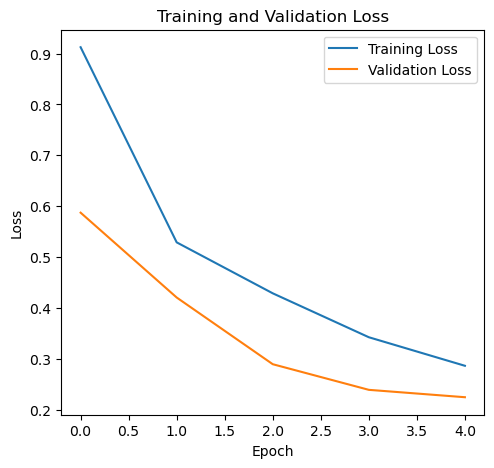

In [38]:
import matplotlib.pyplot as plt
import torch

loss = [l.cpu().numpy() if isinstance(l, torch.Tensor) else l for l in history['loss']]
val_loss = [vl.cpu().numpy() if isinstance(vl, torch.Tensor) else vl for vl in history['val_loss']]

# Plotting the results
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

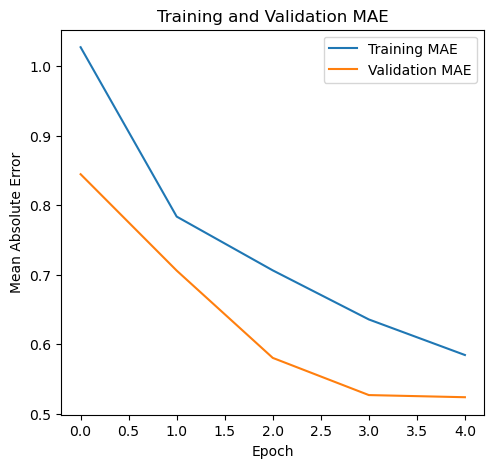

In [39]:
# MAE plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history['mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

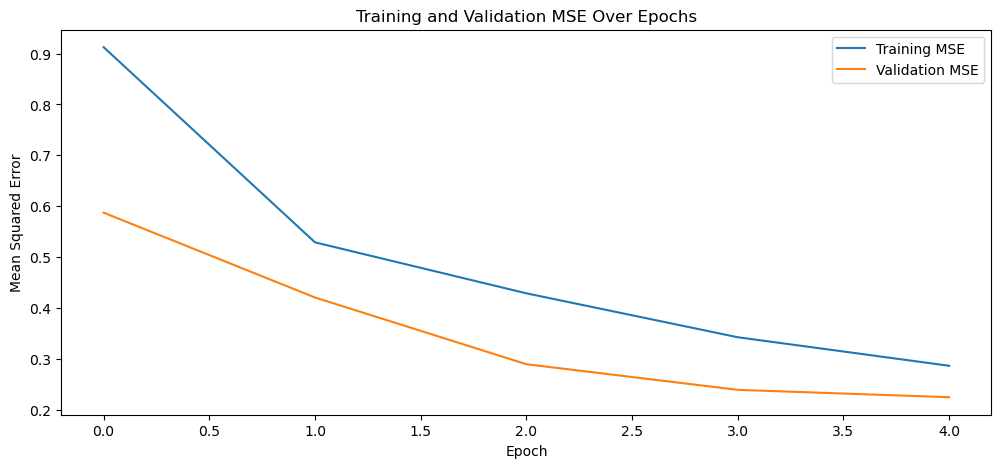

In [47]:
# Graficar el MSE para entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.plot(history['mse'], label='Training MSE')
plt.plot(history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE Over Epochs')
plt.legend()
plt.show()

In [40]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [41]:
model.eval()
predictions = []
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.cpu().numpy())

In [42]:
submission_df = pd.DataFrame({
    'student_id': test_data['student_id'],
    'content': [pred[0] for pred in predictions],
    'wording': [pred[1] for pred in predictions]
})

submission_df.to_csv('submission.csv', index=False)

In [43]:
submission_df

,student_id,content,wording
5732,25b5c1c2329a,-0.580737,-0.972046
5733,19cf2c24b36c,0.069538,0.216997
5734,1748b4f689c8,-1.058832,-1.330099
5735,644a97bcfe44,1.205024,0.467393
5736,e838d0e9974c,0.101853,0.643291
...,...,...,...
7160,e6bb63618f22,-1.170019,-0.667066
7161,aca0b76fb544,1.933372,1.630551
7162,b1ef4a5f28d4,-1.206943,-1.035589
7163,988369638777,-0.627103,-0.152023


In [44]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_data['content'], submission_df['content']), mean_squared_error(test_data['wording'], submission_df['wording'])
# calcular r2
from sklearn.metrics import r2_score

r2_score(test_data['content'], submission_df['content']), r2_score(test_data['wording'], submission_df['wording'])

print("MSE wording: ", mean_squared_error(test_data['wording'], submission_df['wording']))
print("MSE content: ", mean_squared_error(test_data['content'], submission_df['content']))
print("R2 wording: ", r2_score(test_data['wording'], submission_df['wording']))
print("R2 content: ", r2_score(test_data['content'], submission_df['content']))

MSE wording:  0.35062684417095424
MSE content:  0.19557432684328613
R2 wording:  0.6710949751685844
R2 content:  0.8155113885467206


In [45]:
torch.save(model.state_dict(), 'bert.pth')